硬件友好的并行随机光量子芯片实现VQE
======================================

*前置模块*

[关于玻色采样的介绍](https://github.com/TuringQ/deepquantum/blob/main/examples/gbs/boson_sampling/boson_sampling.ipynb)

[光量子实现VQE](https://github.com/TuringQ/deepquantum/blob/main/examples/gbs/vqe_ground_energy_for_H2_alg/vqe_ground_energy_h2.ipynb)

引言
------
在案例*氢分子基态能量求解的基础理论*中，引入了费米子体系到玻色子体系的映射，并展示了在光量子芯片中，如何使用玻色采样和高斯玻色采样实现VQE。
在实践中，ansatz的大小和变分的需求都为实验验证增添了难度。
此案例借鉴了论文[1]变分蒙特卡洛算法VQCMC的思路：对于表达能力不强的ansatz，构建随机线路采样池，以实现扩大ansatz表达能力的效果。
特别的，由于光量子芯片可片上集成、量产的特点，我们可以利用多张参数不同的芯片构建采样池，并行地计算任务需要的观测量，经典地优化权重函数以得到系统最优解。


变分量子算法
------

在DeepQuantum中，我们已经展示了若干从简单、中级到困难的变分量子算法（VQA）的案例👇

[变分量子算法案例](https://deepquantum.turingq.com/category/quantum-variational-algorithm/)

[变分高斯玻色采样的训练](https://github.com/TuringQ/deepquantum/blob/main/examples/gbs/variational_gbs/variational_gbs.ipynb)

变分量子算法的关键流程，是构建一个参数化的量子线路（Ansatz） $ \left |\psi(\theta) \right \rangle = U(\theta) \left |0 \right \rangle ^{\otimes n} $，测量得到损失函数 $L(\theta)$ , 通过找到使损失函数最小的最优参数 $\theta$ 来得到问题的解。


<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/vqa_deterministic.png" width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

VQA的成功与否取决于变分量子线路的表达能力，也就是变分波函数可表达的量子态集合（图中深蓝区域）的大小。

如图所示，如果问题的解在对应的量子态在该集合中（如点a），则通过变分训练理论上能够成功找到解；

若解在集合外，但在集合外一定阈值范围内（如点b），则在置信范围内也能得到问题的解；

若解远离该集合，VQA则会失败。


<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/subset_expressive_ability.png" title='变分波函数表达能力集合' width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>



随机线路采样的量子-经典循环反馈策略
------
通常我们可以通过复杂化变分量子线路的方式来提升表达能力，例如增加Ansatz内量子门数，增加Ansatz数量等。
然而，量子门数在硬件端受到限制[2][3]，而梯度消失、贫瘠高原的问题[4][5]给软件优化算法带来了瓶颈。

有幸的是，通过优化量子-经典循环反馈中的策略来提高表达能力这一点仍有待探索的空间。
论文[1]介绍了一种利用随机线路采样的思路：通过神经网络构建一个决定了采样概率分布的参数化引导函数 $\alpha(\theta; \lambda)\ $，通过马尔可夫链蒙特卡洛方法进行采样。与经典VQA算法不同，不通过优化 $\theta$，而是通过优化参数化的引导函数 $\alpha(\theta; \lambda)$ 来解决问题。

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./fig/vqa_random_circuit.png" width="60%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

研究团队将该变分量子线路蒙特卡洛（VQCMC）算法应用于六比特的反铁磁海森堡模型求解基态能量的问题中，得到了比传统VQE数值模拟结果更精确的解。

代价是更高的时间成本，对于从样本空间中每一条被马尔科夫链采样的量子线路都需要被测量，因此假设样本数量为M，则时间成本至少被提高了M倍。
根据论文[6]的简单测算，具有量子优势的有效VQA时间成本以年为单位，那么以此仍需提高M倍的耗时显然是难以被接受的。

NISQ时代光量子芯片的完美适配
------
以往在考虑量子算法的时间成本时，往往默认了量子线路只有一条，所有的测量无论有没有前后的依赖关系，都会被认为是串联式的时间叠加。
这符合目前的硬件水平，无论是超导、离子阱、中性原子平台的量子计算芯片，都难以实现量产。

暂时唯一有量产潜力的光量子计算芯片为并联式的计算提供了可能，但目前面临规模小且难以实时调控变分的问题。

利用随机线路采样的量子-经典循环反馈策略，我们可以对于表达能力不强的Ansatz（单张浅层光量子芯片），构建大容量的样本空间以提升整体系统的可表达性（组合随机多芯片集群），测量和构建损失函数（并行对集群进行测量，根据权重得到期望），通过经典方法优化权重函数，得到问题的解。

在此算法中，无需对线路参数进行变分，既硬件友好，也节省了单独测量每个参数梯度的时间（对于梯度优化的VQA），或节省了迭代次数（对于非梯度优化的VQA）。

接下来，我们将在案例 [光量子实现VQE](https://github.com/TuringQ/deepquantum/blob/main/examples/gbs/vqe_ground_energy_for_H2_alg/vqe_ground_energy_h2.ipynb) 同个问题中，展示该算法的有效性。

随机线路采样的光量子VQE代码实现
------

在$H_2$基态能量的理论求解案例中已经展示了利用两模BS线路和GBS线路，对于求解$H_2$基态能量随原子核距离变化的问题，得到了和“金标准”FCI一致的解，但是在变分GBS线路用了8个单模门和1个BS门。如果硬件达不到该要求，只能实现如下6个单模门和1个BS门，则常规的变分VQE方法无法得到好的解。

In [1]:
import deepquantum as dq
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import io

dic = io.loadmat('boson_coeff2.mat')
g1 = dic['g1'][0]
g2 = dic['g2'][0]
g3 = dic['g3'][0]
g4 = dic['g4'][0]
g5 = dic['g5'][0]

In [2]:
nmode = 2
cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='fock', basis=False)
cir.s(0, r=1)
cir.s(1, r=1)
cir.d(0, r=1)
cir.d(1, r=1)
cir.ps(0)
cir.ps(1)
cir.bs([0,1])
cir.draw()

In [3]:
def exp_h_gbs_fock(paras):
    s1, s2 = torch.nn.functional.normalize(abs(paras[0:2]), dim=0) # 归一化
    nmode = 2
    cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='fock', basis=False)
    cir.s(0, r=s1)
    cir.s(1, r=s2)
    cir.d(0, r=paras[2])
    cir.d(1, r=paras[3])
    cir.ps(0, paras[4])
    cir.ps(1, paras[5])
    cir.bs([0,1], inputs=[paras[6], paras[7]])

    state = cir()
    p_00 = state[0][0,0]
    p_01 = state[0][0,1]
    p_10 = state[0][1,0]
    p_11 = state[0][1,1]
    p_20 = state[0][2,0]
    p_02 = state[0][0,2]

    p_list = torch.stack([p_00, p_01, p_10, p_11, p_20, p_02])
    p_00_,p_01_,p_10_,p_11_,p_20_,p_02_ = torch.nn.functional.normalize(p_list, dim=0)

    exp_h  = g_1*abs(p_00_)**2 + g_2*abs(p_02_)**2 + g_3*(abs(p_01_)**2+ abs(p_20_)**2) + \
             g_4 *(abs(p_10_)**2 + abs(p_11_)**2) + g_5*(p_00_.conj()*p_02_+p_00_*p_02_.conj()) - \
             g_5* (p_20_.conj()*p_01_+p_20_*p_01_.conj()) # see

    return (exp_h).real

In [4]:
loss_gbs3 = [ ]
for idx in range(50):
    g_1 = g1[idx]
    g_2 = g2[idx]
    g_3 = g3[idx]
    g_4 = g4[idx]
    g_5 = g5[idx]

    angles = torch.nn.Parameter(torch.randn(8))
    optimizer =  torch.optim.Adam([angles], lr=0.1)
    for epoch in range(150):
        optimizer.zero_grad()
        loss = exp_h_gbs_fock(angles)
        loss.backward() # backpropagetion
        optimizer.step() # update parameters
    loss_gbs3.append(loss)
    print(idx,loss,end='\r')

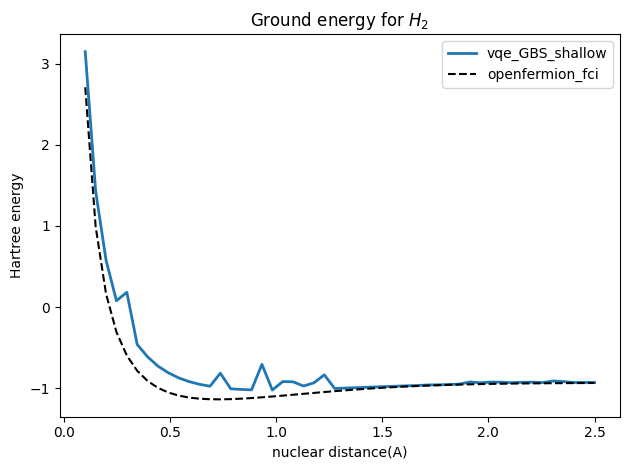

In [5]:
R_values = np.linspace(0.1, 2.5, 50)
hartree_dis = R_values/0.529177 # using Bohr radius
fig =  plt.figure()
nuclear_v = 1/hartree_dis
openfermion_h2_fci = np.load('openfermion_h2_fci.npy')
plt.plot(R_values, torch.stack(loss_gbs3).detach().numpy() + nuclear_v,lw=2, label='vqe_GBS_shallow')
plt.plot(R_values, openfermion_h2_fci[0:50], ls='--', label='openfermion_fci', color='black')
plt.ylabel('Hartree energy')
plt.xlabel('nuclear distance(A)')
plt.title('Ground energy for $H_2$')
plt.legend()
plt.tight_layout()

如果应用并行随机线路的思想，我们使用相同甚至更浅的ansatz, 通过DeepQuantum的data batch输入功能模拟多张GBS芯片，模拟对整个ansatz池进行并行计算，通过训练每张芯片对应的权重，可以得到与FCI接近的结果：

每张芯片使用的线路如下，对应的参数是随机参数：

In [6]:
nmode = 2
cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='fock', basis=False)
cir.s(0, r=1)
cir.s(1, r=1)
cir.ps(0)
cir.ps(1)
cir.bs([0,1])
cir.draw()

In [7]:
def exp_h_gbs_fock(paras,w):
    # s1, s2 = torch.nn.functional.normalize(abs(paras[0:2]), dim=0) # 归一化
    nmode = 2
    cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='fock', basis=False)
    cir.s(0, encode=True)
    cir.s(1,encode=True)
    cir.ps(0,encode=True)
    cir.ps(1,encode=True)
    cir.bs([0,1], encode=True)
    state = cir(data = paras)

    p_00 = state[:,0,0]
    p_01 = state[:,0,1]
    p_10 = state[:,1,0]
    p_11 = state[:,1,1]
    p_20 = state[:,2,0]
    p_02 = state[:,0,2]
    p_list = torch.stack([p_00, p_01, p_10, p_11, p_20, p_02])
    p_00_,p_01_,p_10_,p_11_,p_20_,p_02_ = torch.nn.functional.normalize(p_list, dim=0)
    exp_h  = g_1*abs(p_00_)**2 + g_2*abs(p_02_)**2 + g_3*(abs(p_01_)**2+ abs(p_20_)**2) + \
             g_4 *(abs(p_10_)**2 + abs(p_11_)**2) + g_5*(p_00_.conj()*p_02_+p_00_*p_02_.conj()) - \
             g_5* (p_20_.conj()*p_01_+p_20_*p_01_.conj()) # see
    w = torch.nn.functional.softmax(w, dim=0)
    return (exp_h).real @ w

这里设置batch=100来模拟100 张GBS芯片, 通过训练100个权重来做变分任务。

In [8]:
batch = 100
loss_gbs_4 = [ ]
for idx in range(50):
    idx = idx
    g_1 = g1[idx]
    g_2 = g2[idx]
    g_3 = g3[idx]
    g_4 = g4[idx]
    g_5 = g5[idx]

    angles = torch.rand(8*batch).reshape(batch,8)
    angles[:,1] = 0.
    angles[:,3] = 0.
    w = torch.nn.Parameter(torch.rand(batch,1))
    optimizer =  torch.optim.Adam([w], lr=0.1)
    for epoch in range(150):
        optimizer.zero_grad()
        loss = exp_h_gbs_fock(angles,w)
        loss.backward() # backpropagetion
        optimizer.step() # update parameters
    loss_gbs_4.append(loss)
    print(idx,loss,end='\r')

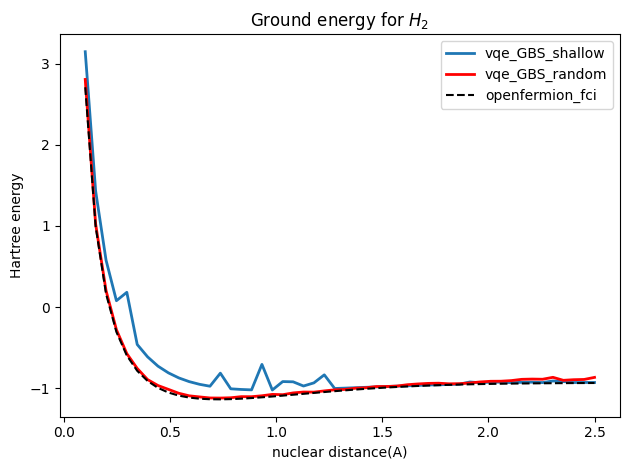

In [9]:
fig =  plt.figure()
plt.plot(R_values, torch.stack(loss_gbs3).detach().numpy() + nuclear_v,lw=2, label='vqe_GBS_shallow')
plt.plot(R_values, torch.stack(loss_gbs_4).mT[0].detach().numpy() + nuclear_v,lw=2, label='vqe_GBS_random',color='red')
plt.plot(R_values, openfermion_h2_fci[0:50], ls='--', label='openfermion_fci', color='black')
plt.ylabel('Hartree energy')
plt.xlabel('nuclear distance(A)')
plt.title('Ground energy for $H_2$')
plt.legend()
plt.tight_layout()

# 参考文献

[1] Yang Y, Zhang Z, Wang A, et al. Maximizing quantum-computing expressive power through randomized circuits[J]. Physical Review Research, 2024, 6(2): 023098.

[2] Ostaszewski M, Grant E, Benedetti M. Structure optimization for parameterized quantum circuits[J]. Quantum, 2021, 5: 391.

[3] Choquette A, Di Paolo A, Barkoutsos P K, et al. Quantum-optimal-control-inspired ansatz for variational quantum algorithms[J]. Physical Review Research, 2021, 3(2): 023092.

[4] Pesah A, Cerezo M, Wang S, et al. Absence of barren plateaus in quantum convolutional neural networks[J]. Physical Review X, 2021, 11(4): 041011.

[5] Patti T L, Najafi K, Gao X, et al. Entanglement devised barren plateau mitigation[J]. Physical Review Research, 2021, 3(3): 033090.

[6] Liu H Y, Chen Z Y, Sun T P, et al. Can variational quantum algorithms demonstrate quantum advantages? Time really matters[J]. arXiv preprint arXiv:2307.04089, 2023.